## Анализ различий в состояниях

Идея 1. Предположим, что полная выборка - это ground true. Оставляем только значимые пары с FDR коррекцией 0.05.    Анализируем как воспроизводятся индивидуальные эффекты: индивидуально, частость каждого ребра (отдельно положительного, отдельно отрицательного). Считаем precision, recall для разных подгруп. Смотрим насколько воспроизводится паттерн целиком (dice эффект).
	1) Можно сделать для разных способов коррекции
	2) Протестировать насколько NBS может изменить ситуацию
	3) Проверить IHW подход и получить веса на полной выборке
**Зачем это надо**  Во первых опубликуем полученные эффекты, которые можно использовать (например как мы сами во второй части). Получим оценки размеров эффектов, шансы на их выявления по размерам групп, оценки Точности (доля правильно выявлянных эффектов) и Полноты (доля выявлянных эффектов) для подгруппы и сделаем какие то рекомендации по размерам. Сравним разные способы коррекции на множественные сравнения и посмотрим насколько хорош подход с nbs
3) Идея 2. Нет никакой ground true, можем брать выборки меньших размеров и смотреть следующее:
	1) Частость паттерна при разных коррекциях (чем выше, тем лучше) для подгрупп
	2) Dice для подгрупп
	3) добавляем веса с IHW
В качестве значимых берем:
 - нескорректированный p-val (одно экстремальное состояние)
 - коррекцию на множественные сравнения (тогда вообще надо объединять все гипотезы и все бэнды в один датасет):
	 - fwer
	 - fdr (+версии)
	 -  nbs
	 - ihw+ все способы, веса получаем из ground true. Как это использовать другими? Мы можем опубликовать веса для каналов и предлагать их использовать в схожих задачах как ковариату, например если нам надо убрать эффект открытых закрытых глаз или наоборот проверить. 
Оценки для множественных сравнений и  ihw отсюда : https://puolival.github.io/multipy/

**Зачем это надо**  Получим оценки воспроизводимости для разных размеров групп и сравним разные способы коррекции, посмотрим как априорное знание позволяет улучшить вариант. От первого пункта основное отличие в том, что нет ground true, к которому можно придраться

In [1]:
import sys
sys.path.append("..")

In [41]:
from table_analyzer import SynchronizationTable, bool_dice, vec_2_arr_bool_dice
from table_analyzer import SubsampleTable
from plotting_utils import DrawEEG
from table_analyzer import pairwise_bool_dice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv('../eeg_dataframe_nansfilled.csv', index_col=0)
df.head()

,Fp1/Fp2_1_fo,Fp1/F7_1_fo,Fp1/F3_1_fo,Fp1/Fz_1_fo,Fp1/F4_1_fo,Fp1/F8_1_fo,Fp1/T3_1_fo,Fp1/C3_1_fo,Fp1/Cz_1_fo,Fp1/C4_1_fo,...,Pz/P4_7_fz,Pz/T6_7_fz,Pz/O1_7_fz,Pz/O2_7_fz,P4/T6_7_fz,P4/O1_7_fz,P4/O2_7_fz,T6/O1_7_fz,T6/O2_7_fz,O1/O2_7_fz
abs_,-0.067816,-0.190843,0.197049,0.082941,-0.431078,-0.880805,-1.597362,-0.486399,-0.505033,-0.634386,...,-0.369614,-1.591706,-0.671730,-0.722746,-1.030530,-1.353433,-0.547397,-2.283078,-0.838246,-1.366732
agv_,-0.063064,0.149510,-1.470177,-2.307671,-4.443682,-1.542283,-1.490230,-1.053519,-1.771533,-3.276315,...,-0.399129,-1.244996,-0.463251,-0.535564,-1.440858,-1.157720,-0.681816,-1.764711,-0.533204,-1.412399
ami_,-0.456335,-0.437952,-0.133411,-0.656705,-0.498032,-1.281238,-1.952807,-1.150458,-1.865200,-1.718330,...,-0.100816,-0.595306,-0.283766,-0.117159,0.246866,-0.786120,0.194194,-0.788818,-0.051139,-0.387762
ast_,-1.161369,-1.080370,-1.011179,-1.569420,-3.917162,-2.127779,-2.692695,-2.732259,-2.059262,-3.841575,...,-0.077291,-1.674175,-0.636853,-0.970301,-0.401405,-0.866471,0.059785,-1.264972,0.262019,-0.799658
avk_,-1.344665,-3.841575,-4.795873,-3.105343,-3.917162,-2.839805,-1.620330,-3.074839,-2.087983,-1.828024,...,-0.516737,-2.283078,-0.907005,-0.545027,-1.792309,-2.550227,-1.661937,-0.818822,-0.491047,-0.869325


In [87]:
%%time
sample_sizes = [20,25,30,35,40,45,50,60,70,80,90]
for sample_size in sample_sizes:
    table = SynchronizationTable(df)
    subs_table = SubsampleTable(table)
    n=10 if sample_size<50 else 20
    merged_dict, merged_df = subs_table.repeat_n_subgroup_stats(n=n, size=sample_size, bts_num=1000, eff_thrs=(0.05, 0.1, 0.15) )
    merged_df.to_csv(f'../repr_results/repr_df_{sample_size}.csv')
    dice_dict = pd.DataFrame(merged_dict)
    melted_dice = dice_dict.melt(value_name = 'dice_coeff', var_name  = 'corr_method')
    melted_dice.head()
    melted_dice['corr_method'] = melted_dice[['corr_method']].applymap(lambda x: x[5:])
    melted_dice['sample_size'] = sample_size
    melted_dice.to_csv(f'../repr_results/dice_{sample_size}.csv')

100%|███████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]

CPU times: user 11min 4s, sys: 4.16 s, total: 11min 8s
Wall time: 11min 6s


In [99]:
dice_df = pd.concat([pd.read_csv(f'../repr_results/dice_{sample_size}.csv', index_col=0) 
                     for sample_size in sample_sizes])
dice_df.head()

,corr_method,dice_coeff,sample_size
0,holm_bonferroni,NaN,20
1,holm_bonferroni,0.0,20
2,holm_bonferroni,0.0,20
3,holm_bonferroni,0.0,20
4,holm_bonferroni,0.0,20


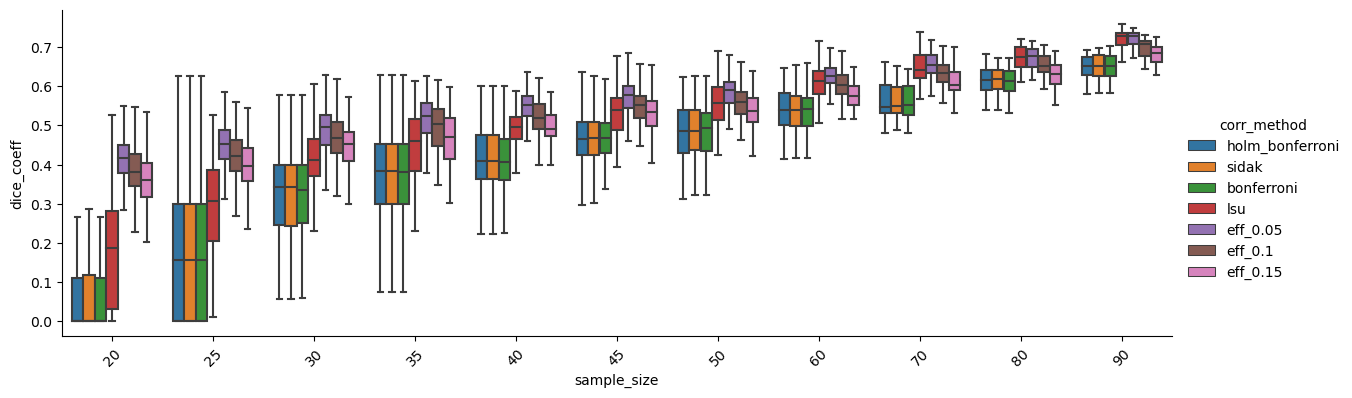

In [102]:
g = sns.catplot(x = 'sample_size',y = 'dice_coeff', hue = 'corr_method', data= dice_df, kind = 'box', 
                height=4, aspect=3, showfliers = False)
g.set_xticklabels(rotation=45);

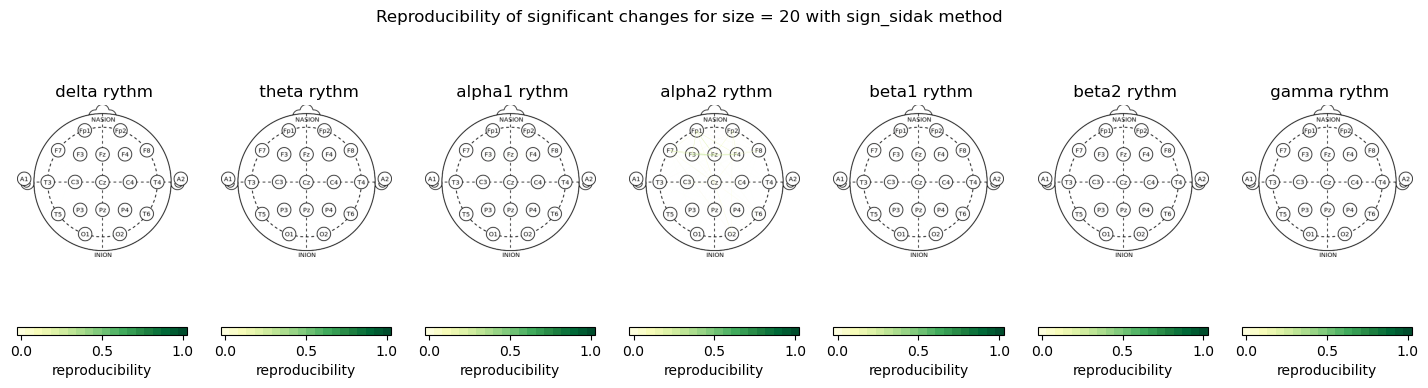

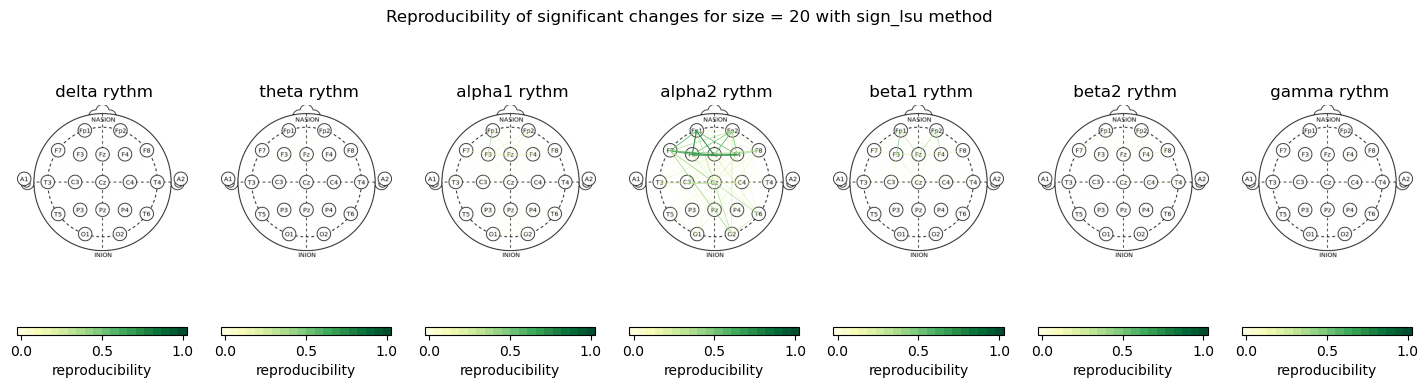

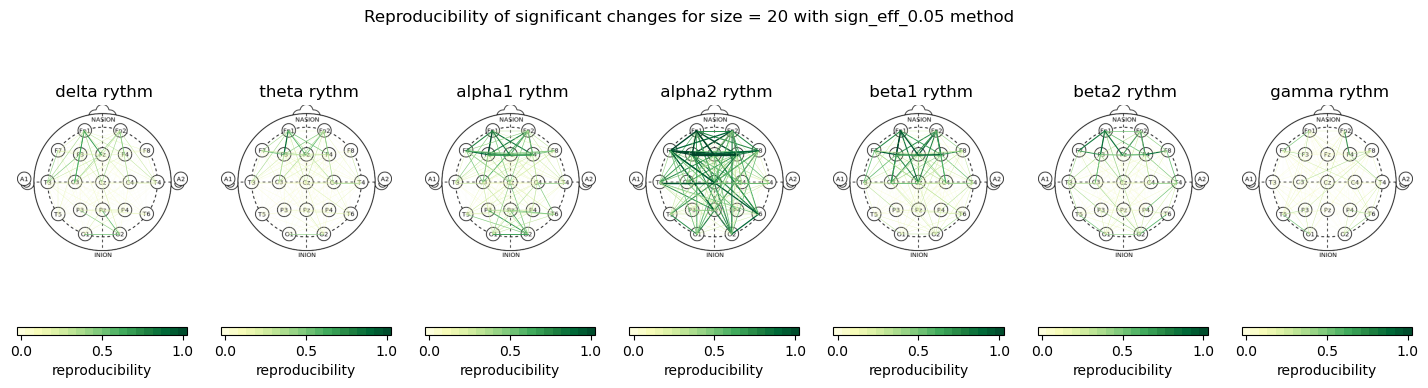

In [111]:
sample_size = 20
repr_df = pd.read_csv(f'../repr_results/repr_df_{sample_size}.csv', index_col=0)
draw_obj = DrawEEG(img_source='../21ch_eeg.png')
methods = ['sign_sidak', 'sign_lsu','sign_eff_0.05']
for method in methods:
    fig = draw_obj.draw_by_df(repr_df, band=tuple(table.key_bands.values()),
                                 filter_by=None,
                                 vmin=0, vmax=1,
                                 color_col=method,
                                 width_col=method,
                                 sign='same',
                                 color_label = "reproducibility",
                                 cmap = cm.YlGn)
    fig.suptitle(f'Reproducibility of significant changes for size = {sample_size} with {method} method ');

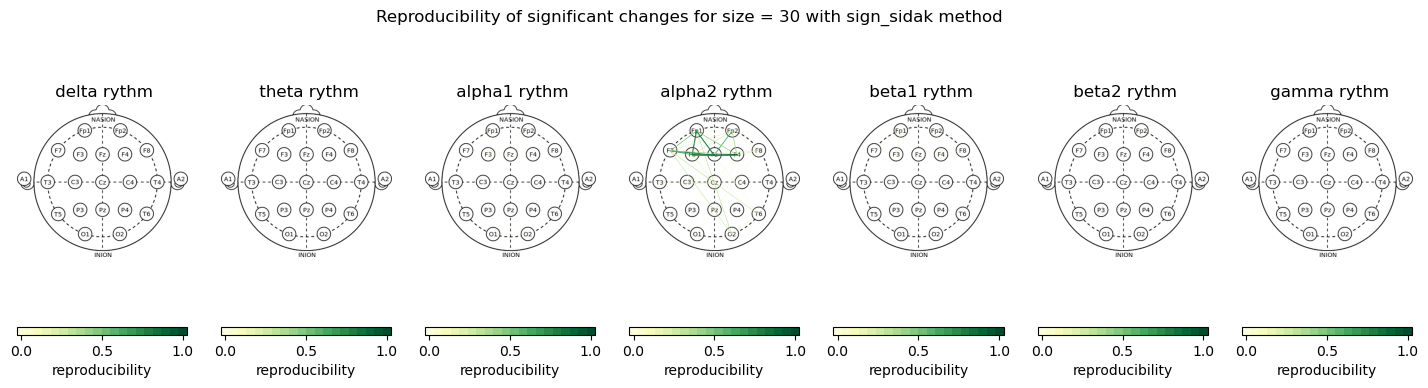

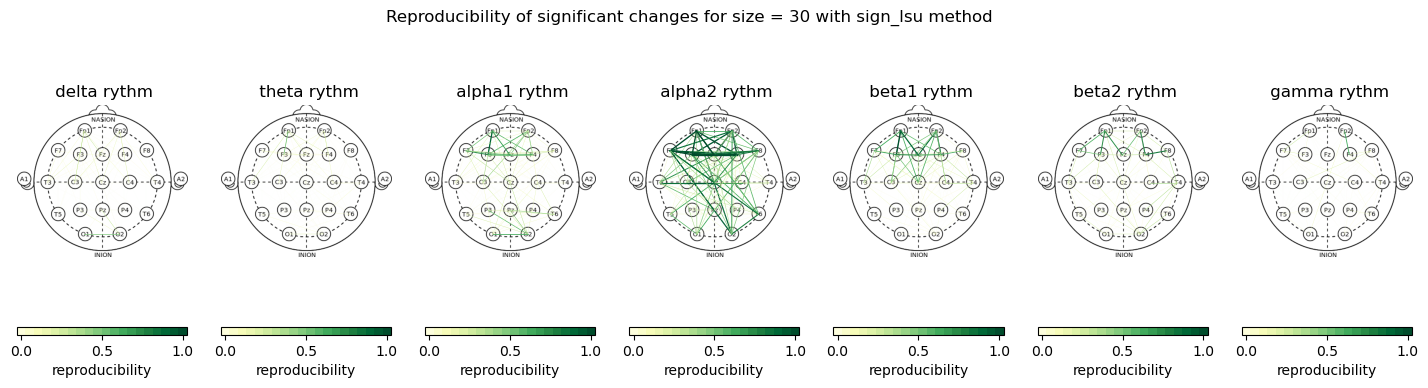

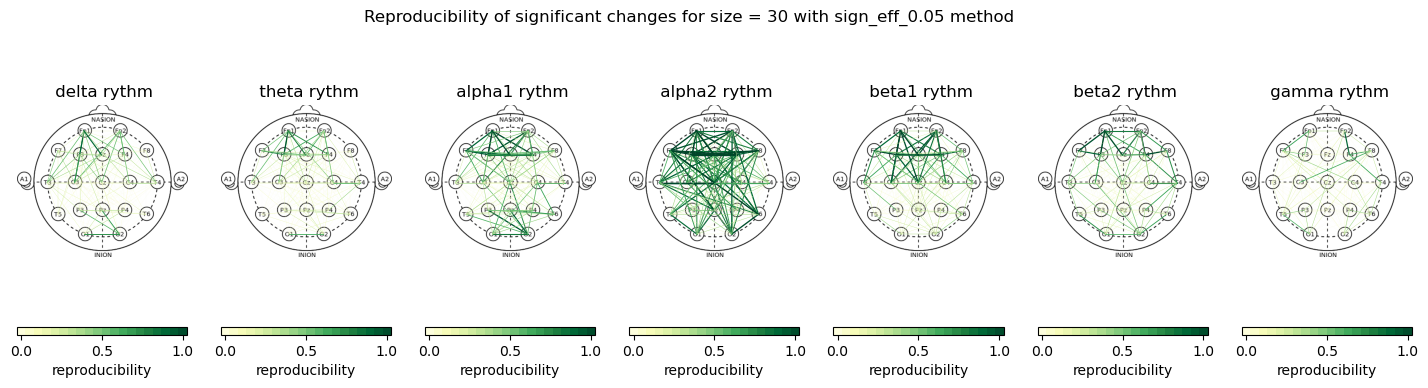

In [112]:
sample_size = 30
repr_df = pd.read_csv(f'../repr_results/repr_df_{sample_size}.csv', index_col=0)
draw_obj = DrawEEG(img_source='../21ch_eeg.png')
methods = ['sign_sidak', 'sign_lsu','sign_eff_0.05']
for method in methods:
    fig = draw_obj.draw_by_df(repr_df, band=tuple(table.key_bands.values()),
                                 filter_by=None,
                                 vmin=0, vmax=1,
                                 color_col=method,
                                 width_col=method,
                                 sign='same',
                                 color_label = "reproducibility",
                                 cmap = cm.YlGn)
    fig.suptitle(f'Reproducibility of significant changes for size = {sample_size} with {method} method ');

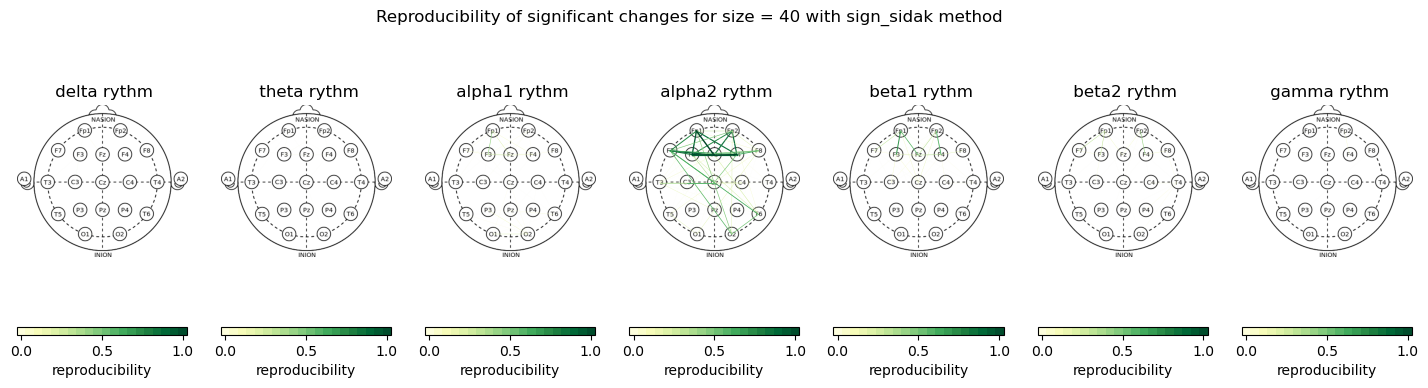

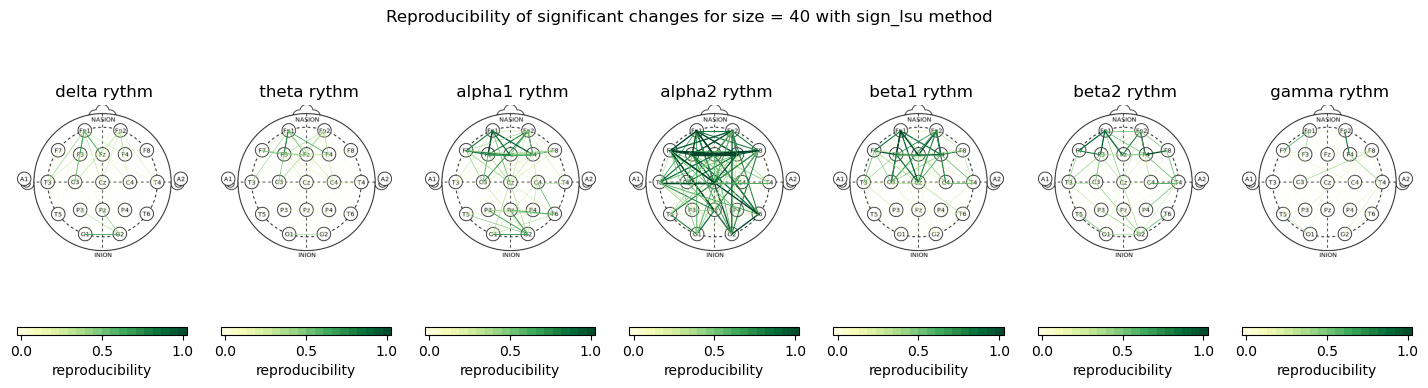

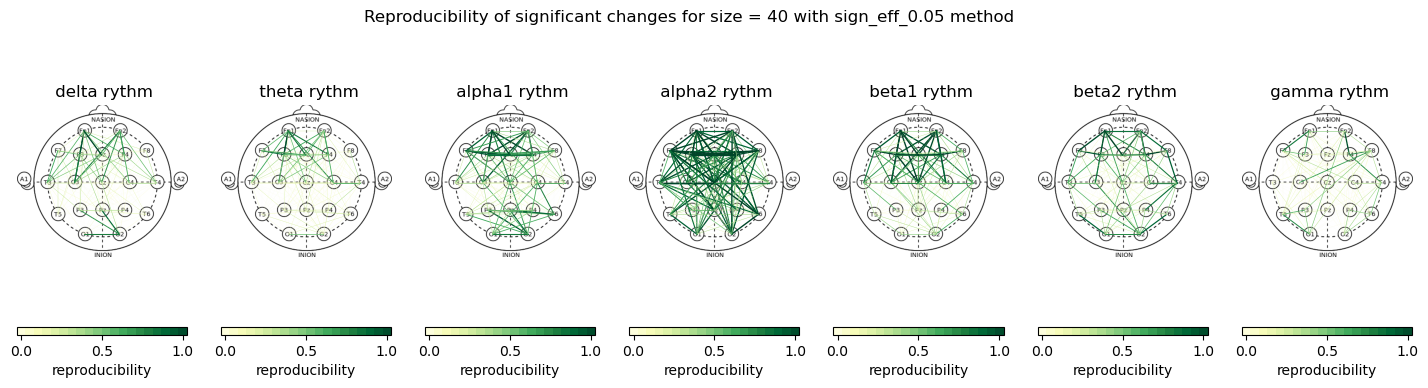

In [113]:
sample_size = 40
repr_df = pd.read_csv(f'../repr_results/repr_df_{sample_size}.csv', index_col=0)
draw_obj = DrawEEG(img_source='../21ch_eeg.png')
methods = ['sign_sidak', 'sign_lsu','sign_eff_0.05']
for method in methods:
    fig = draw_obj.draw_by_df(repr_df, band=tuple(table.key_bands.values()),
                                 filter_by=None,
                                 vmin=0, vmax=1,
                                 color_col=method,
                                 width_col=method,
                                 sign='same',
                                 color_label = "reproducibility",
                                 cmap = cm.YlGn)
    fig.suptitle(f'Reproducibility of significant changes for size = {sample_size} with {method} method ');

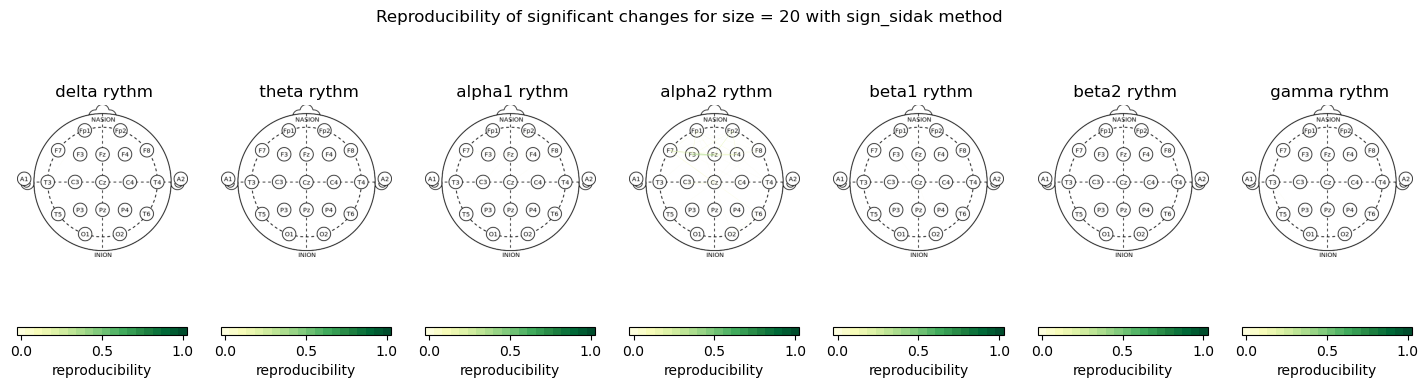

In [30]:
method = 'sign_sidak'
fig = draw_obj.draw_by_df(merged_df, band=tuple(table.key_bands.values()),
                                 filter_by=None,
                                 vmin=0, vmax=1,
                                 color_col=method,
                                 width_col=method,
                                 sign='same',
                                 color_label = "reproducibility",
                                 cmap = cm.YlGn)
fig.suptitle(f'Reproducibility of significant changes for size = {size} with {method} method ');

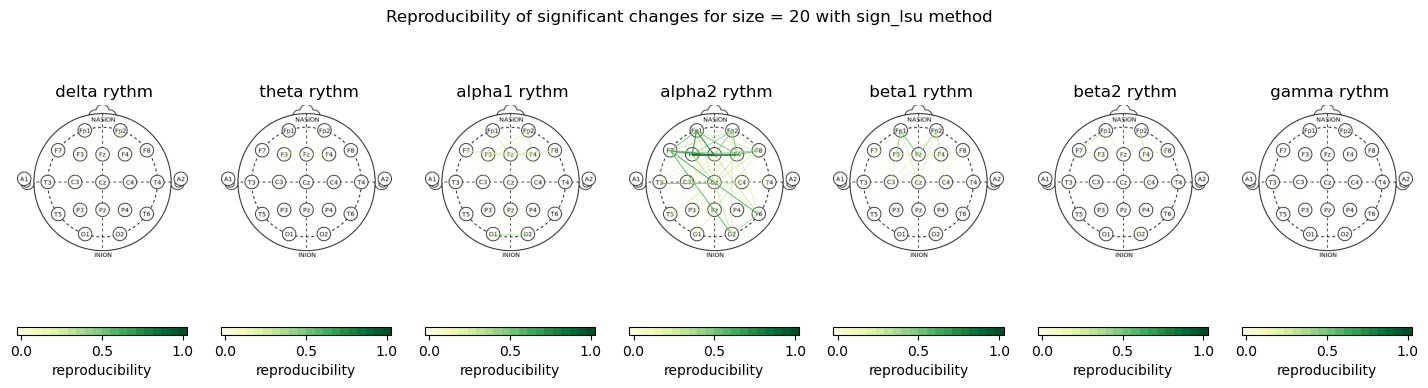

In [31]:
method = 'sign_lsu'
fig = draw_obj.draw_by_df(merged_df, band=tuple(table.key_bands.values()),
                                 filter_by=None,
                                 vmin=0, vmax=1,
                                 color_col=method,
                                 width_col=method,
                                 sign='same',
                                 color_label = "reproducibility",
                                 cmap = cm.YlGn)
fig.suptitle(f'Reproducibility of significant changes for size = {size} with {method} method ');

In [75]:
dice_dict = pd.DataFrame(merged_dict)
melted_dice = dice_dict.melt(value_name = 'dice_coeff', var_name  = 'corr_method')
melted_dice.head()
melted_dice['corr_method'] = melted_dice[['corr_method']].applymap(lambda x: x[5:])
melted_dice['sample_size'] = sample_size

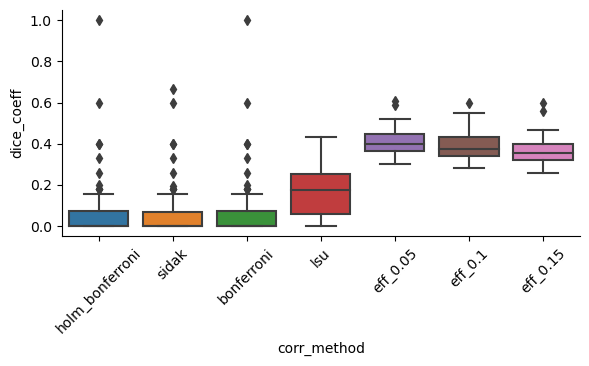

In [42]:
?sns.catplot

Signature:
sns.catplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    row=None,
    col=None,
    col_wrap=None,
    estimator=<function mean at 0x7ff1df303040>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    kind='strip',
    height=5,
    aspect=1,
    orient=None,
    color=None,
    palette=None,
    legend=True,
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None,
    **kwargs,
)
Docstring:
Figure-level interface for drawing categorical plots onto a FacetGrid.

This function provides access to several axes-level functions that
show the relationship between a numerical and one or more categorical
variables using one of several visual representations. The ``kind``
parameter selects the underlying axes-level function to use:

Categorical scatterplots:

- :func:`stripplot` (with ``kind="strip"``; the default)
- :func:`swarmplot` (

In [66]:
stat_df.head()

,chan_pair,band,p_val,sign_holm_bonferroni,sign_sidak,sign_bonferroni,sign_lsu,mean_eff_size,low_eff_size,upper_eff_size
0,F3/T5,delta,1.475137e-03,False,False,False,True,-0.247133,-0.396395,-0.105677
1,F3/F8,delta,5.928767e-03,False,False,False,True,0.210029,0.069918,0.373001
2,T3/T6,delta,5.125442e-01,False,False,False,False,0.048289,-0.100380,0.193490
3,Fp2/C3,delta,1.101652e-07,True,True,True,True,-0.421083,-0.557035,-0.279437
4,C3/Cz,delta,9.100806e-02,False,False,False,False,-0.126848,-0.261290,0.004529


In [67]:
stat_df['sign_eff_range'] = (stat_df['low_eff_size']>0.1) | (stat_df['upper_eff_size']<-0.1)

In [68]:
stat_df['sign_eff_mean'] = (stat_df['mean_eff_size']>0.2) | (stat_df['mean_eff_size']<-0.2)

In [69]:
cols = list(stat_df.filter(regex='sign').columns)

In [70]:
[stat_df[col].sum() for col in cols]

[301, 294, 292, 642, 444, 564]

In [72]:
vec_2_arr_bool_dice(stat_df.sign_eff_mean.values, stat_df.filter(regex='sign').values)

[0.6959537572254335,
 0.6853146853146853,
 0.6822429906542056,
 0.9353233830845771,
 0.8809523809523809,
 1.0]

In [73]:
vec_2_arr_bool_dice(stat_df.sign_eff_range.values, stat_df.filter(regex='sign').values)

[0.8080536912751678,
 0.7967479674796748,
 0.7934782608695652,
 0.8176795580110497,
 1.0,
 0.8809523809523809]

In [43]:
(stat_df.sign_sidak==stat_df.sign_bonferroni).all()

False

In [35]:
bool_dice(stat_df.sign_sidak.values, stat_df.sign_eff_thrs.values)

0.7956698240866035

In [101]:
bands = tuple(full_table.key_bands.values())
bands
print(stat_df.columns)

Index(['chan_pair', 'band', 'p_val', 'sign_holm_bonferroni', 'sign_hochberg',
       'sign_sidak', 'sign_bonferroni', 'sign_lsu', 'sign_abh',
       'mean_eff_size', 'low_eff_size', 'upper_eff_size'],
      dtype='object')


In [104]:
draw_obj = DrawEEG(img_source='../21ch_eeg.png')

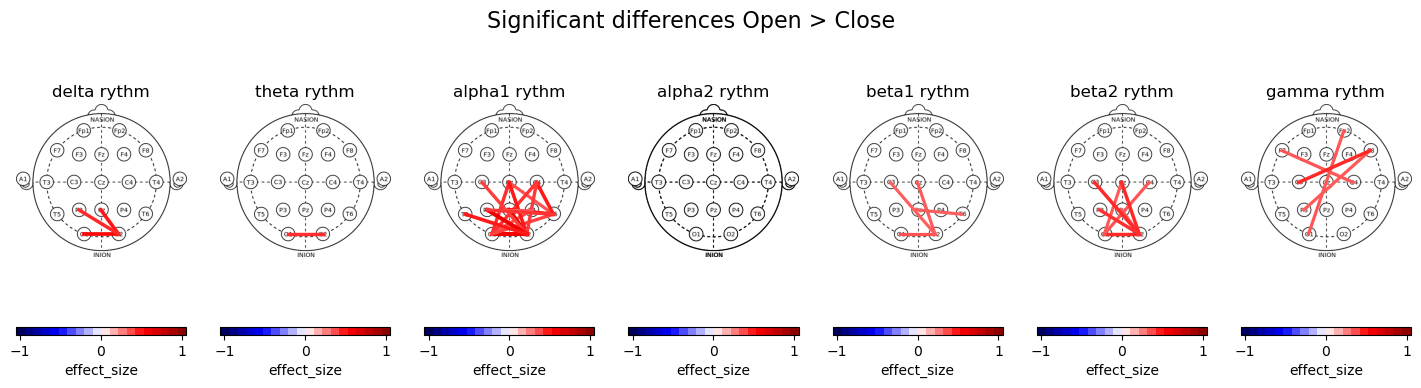

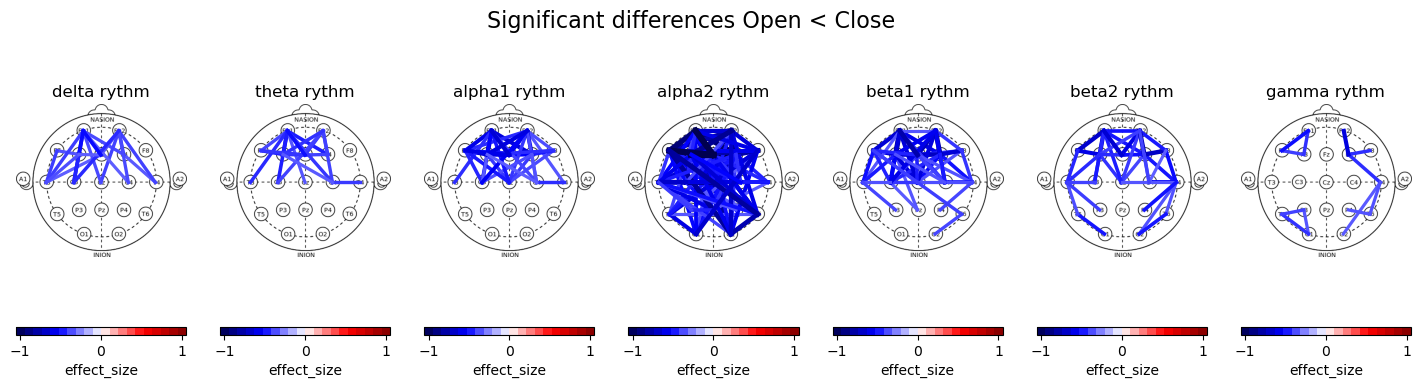

In [105]:
stat_df['width'] = stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_holm_bonferroni',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')
plt.show()

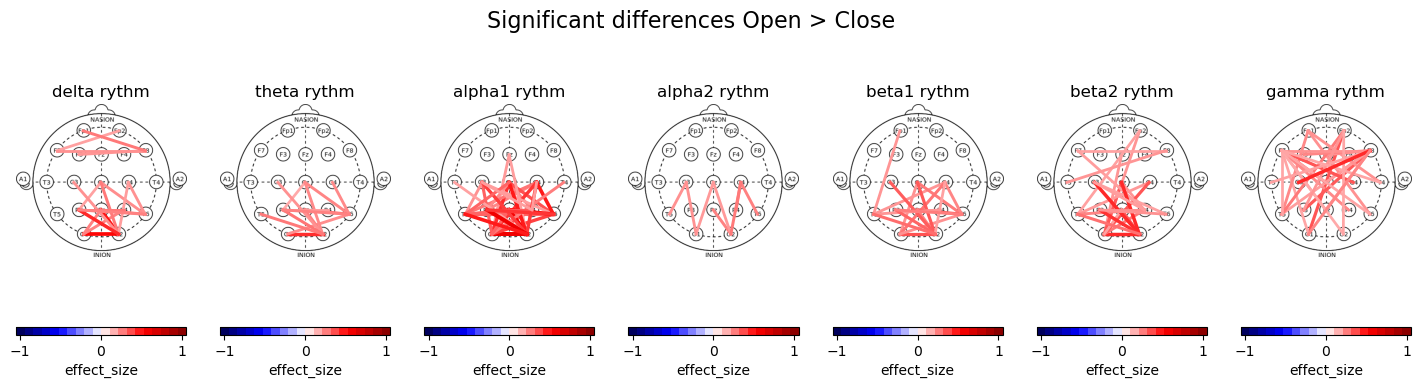

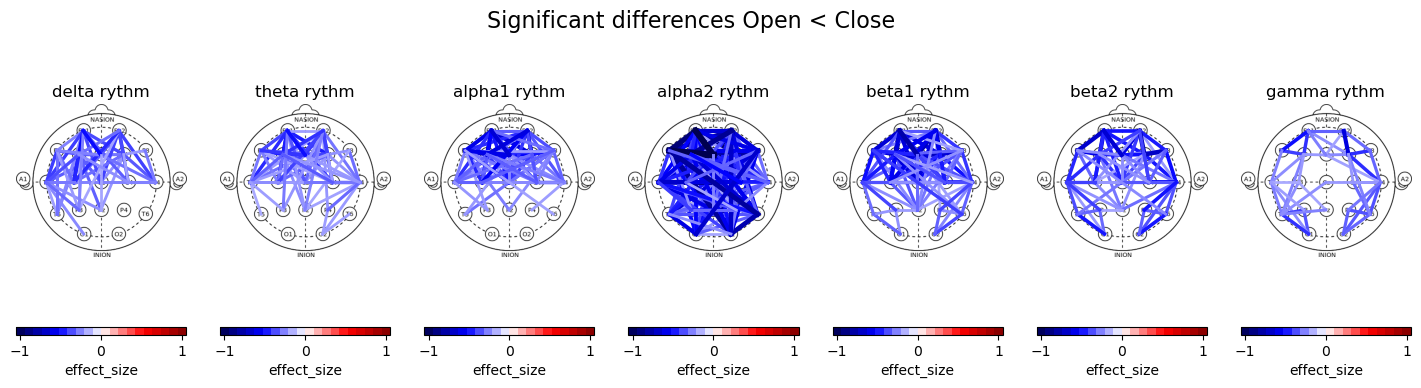

In [107]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')
plt.show()

In [113]:
stat_df

,chan_pair,band,p_val,sign_holm_bonferroni,sign_hochberg,sign_sidak,sign_bonferroni,sign_lsu,sign_abh,mean_eff_size,low_eff_size,upper_eff_size,width,sign_eff_thrs
0,Fp2/O1,delta,6.490125e-01,False,False,False,False,False,False,-0.034279,-0.184989,0.110438,1.706218,False
1,Fz/O1,delta,7.938451e-01,False,False,False,False,False,False,-0.017664,-0.168244,0.131593,1.678102,False
2,P3/O1,delta,3.146559e-01,False,False,False,False,False,False,-0.071358,-0.206863,0.083497,1.770669,False
3,Fp2/P4,delta,7.621522e-02,False,False,False,False,False,False,-0.137115,-0.294644,0.005333,1.891018,False
4,T3/O1,delta,2.232874e-03,False,False,False,False,True,True,-0.234029,-0.364724,-0.098604,2.083457,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,C3/P4,gamma,1.691267e-01,False,False,False,False,False,False,0.103442,-0.042391,0.237737,1.828401,False
1193,T5/O2,gamma,3.418104e-01,False,False,False,False,False,False,-0.070268,-0.214335,0.067410,1.768741,False
1194,F8/C3,gamma,1.301965e-07,True,True,True,True,True,True,0.415298,0.262353,0.558399,2.497518,True
1195,F8/O1,gamma,1.941569e-03,False,False,False,False,True,True,0.237039,0.088201,0.389631,2.089738,False


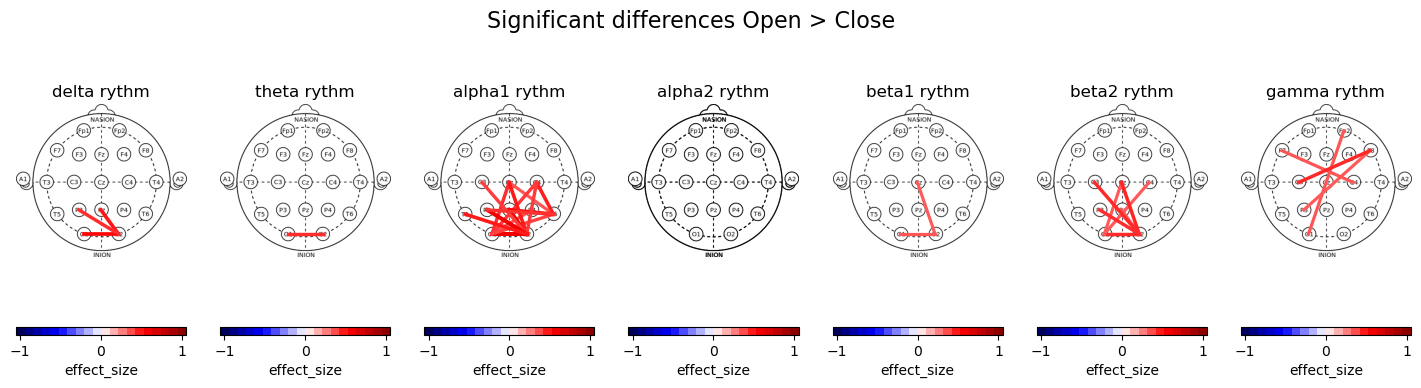

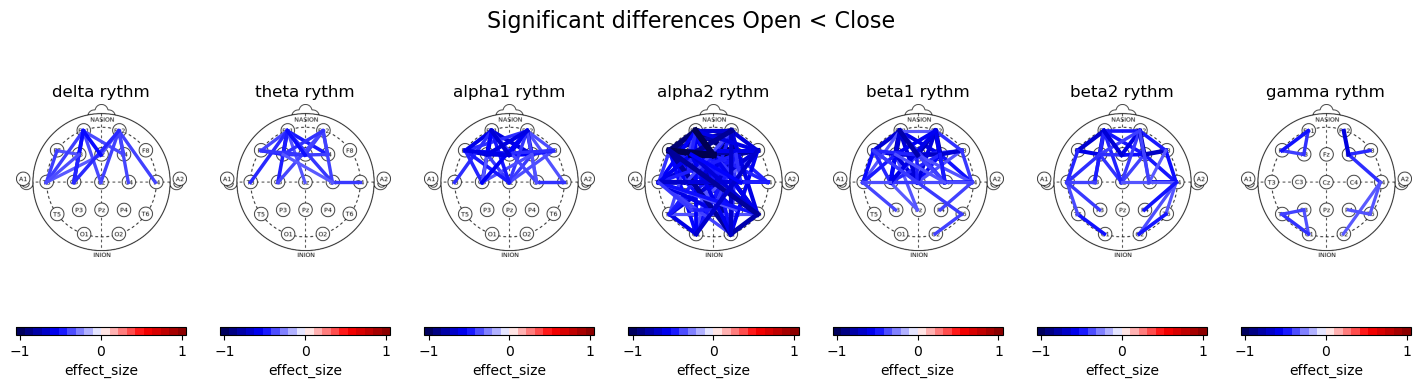

In [25]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_bonferroni',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

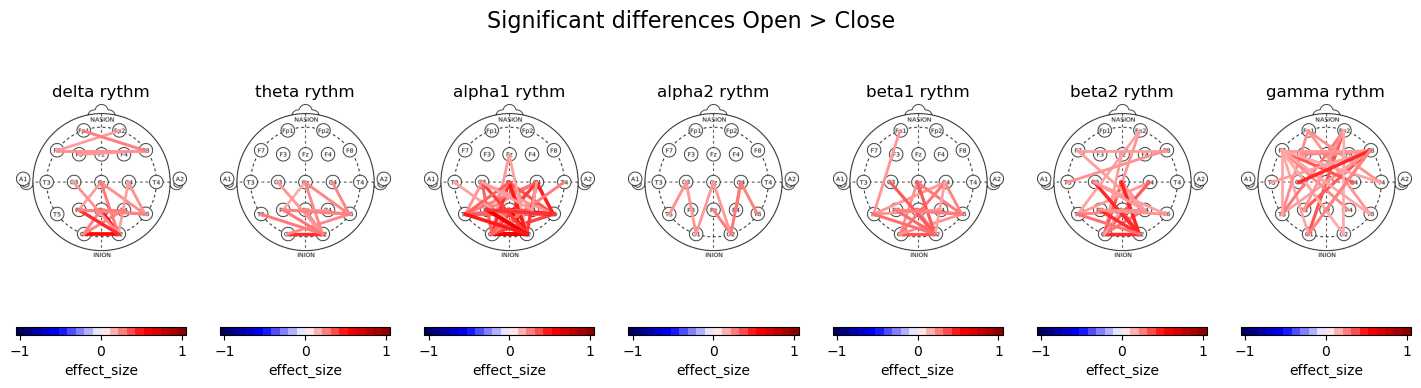

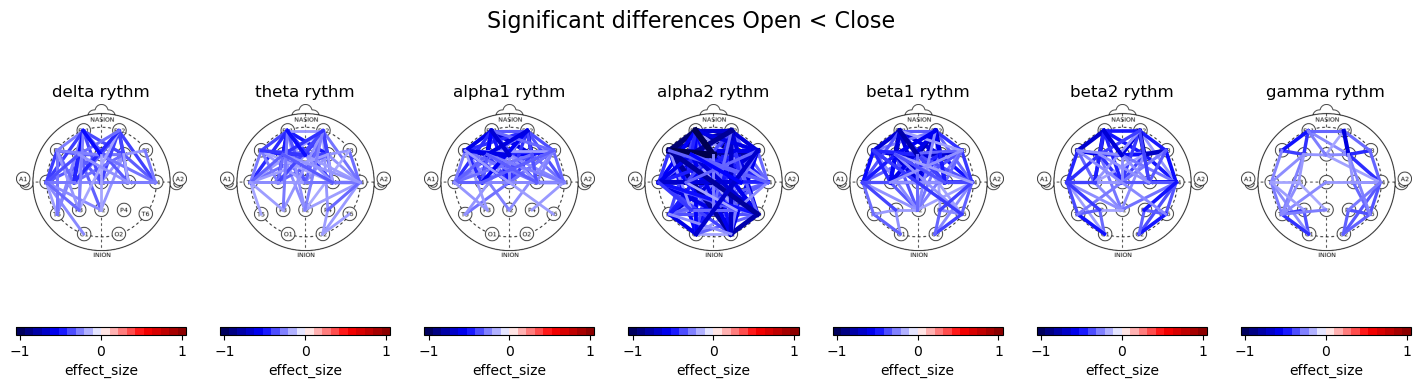

In [27]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_abh',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

In [56]:
((stat_df['low_eff_size']>0.1) | (stat_df['upper_eff_size']<-0.1)).sum()

438

In [110]:
stat_df['sign_eff_thrs'] = (stat_df['low_eff_size']>0.1) | (stat_df['upper_eff_size']<-0.1)

In [111]:
(stat_df['sign_eff_thrs']).sum(), stat_df['sign_abh'].sum()

(448, 642)

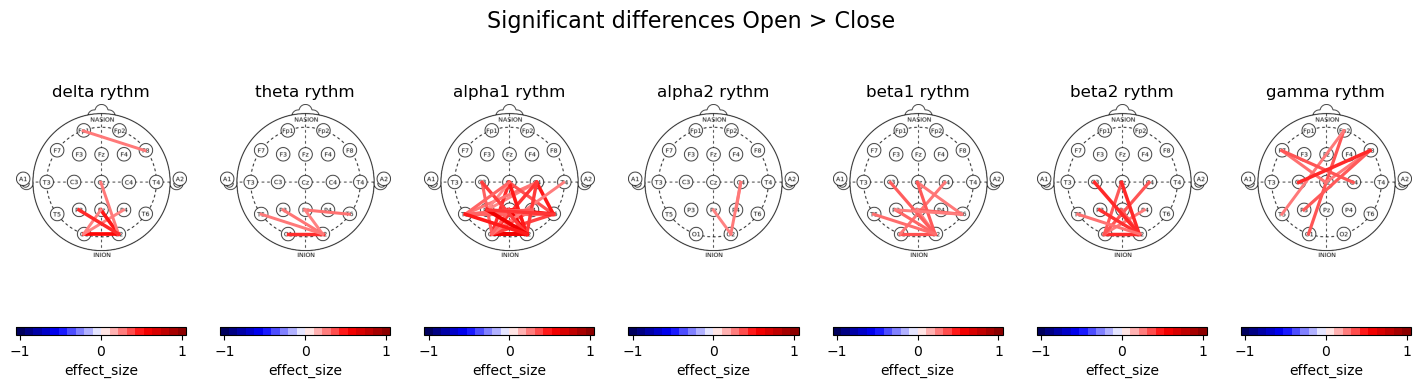

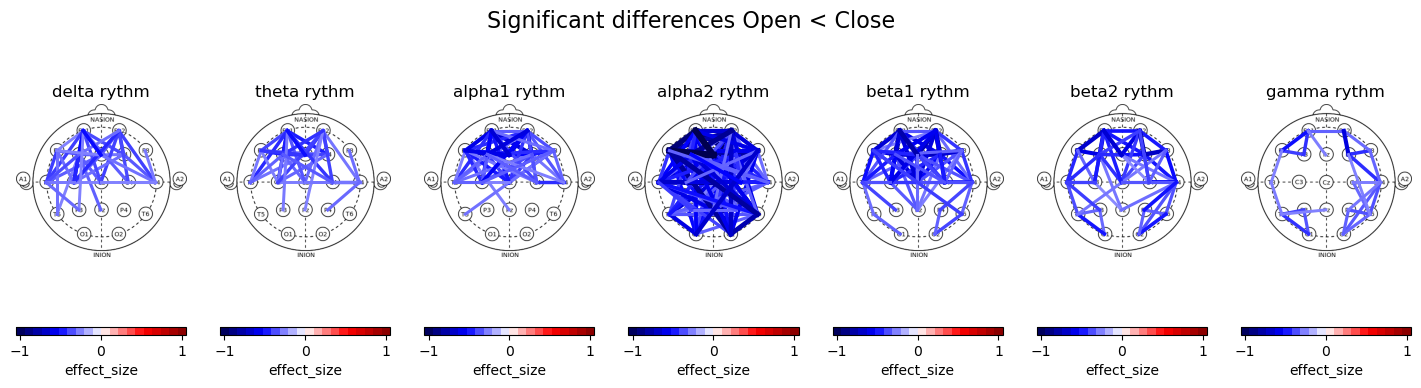

In [112]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_eff_thrs',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

In [54]:
stat_df.filter(regex='sign')

,sign_holm_bonferroni,sign_hochberg,sign_sidak,sign_bonferroni,sign_lsu,sign_abh,sign_eff_thrs
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...
1192,False,False,False,False,False,False,False
1193,False,False,False,False,False,False,False
1194,True,True,True,True,True,True,True
1195,False,False,False,False,True,True,False


In [51]:
arr = stat_df.filter(regex='sign').values

In [55]:
pairwise_bool_dice(arr)

[1.0,
 0.9882352941176471,
 0.984822934232715,
 0.6383881230116649,
 0.6383881230116649,
 0.8146143437077131,
 0.9882352941176471,
 0.984822934232715,
 0.6383881230116649,
 0.6383881230116649,
 0.8146143437077131,
 0.9965870307167235,
 0.6282051282051282,
 0.6282051282051282,
 0.8032786885245902,
 0.6252676659528907,
 0.6252676659528907,
 0.8,
 1.0,
 0.8111111111111111,
 0.8111111111111111]

## Что надо сделать 
Посмотреть как для разных корректировок путешествует значимости

In [91]:
small_df = df.loc[list(np.random.choice(df.index, size=40, replace=False))]

In [92]:
small_table = SynchronizationTable(small_df)
small_stat_df = small_table.compute_stat_df(bts_num=1000)

In [93]:
small_stat_df['sign_eff_thrs'] = (small_stat_df['low_eff_size']>0.05) | (small_stat_df['upper_eff_size']<-0.05)
small_stat_df['width'] = small_stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))

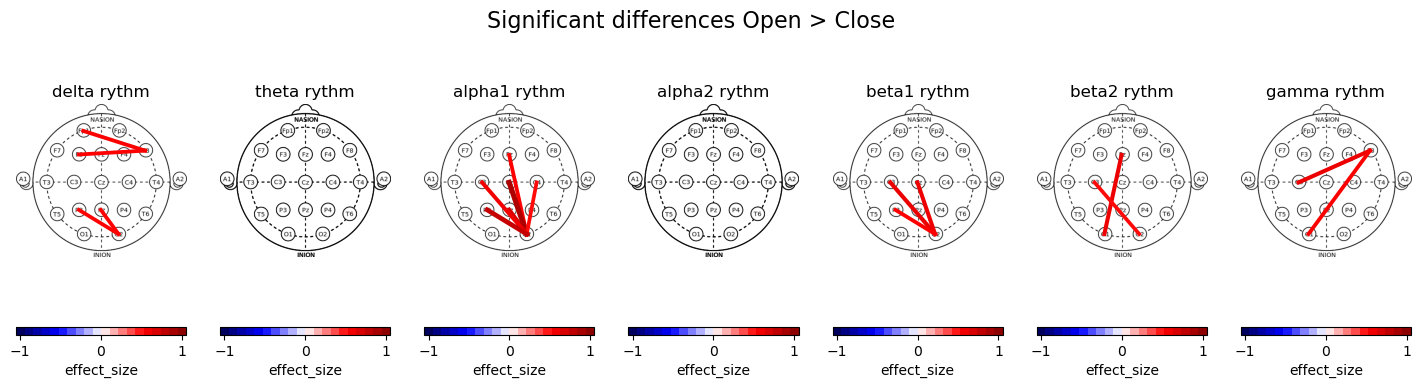

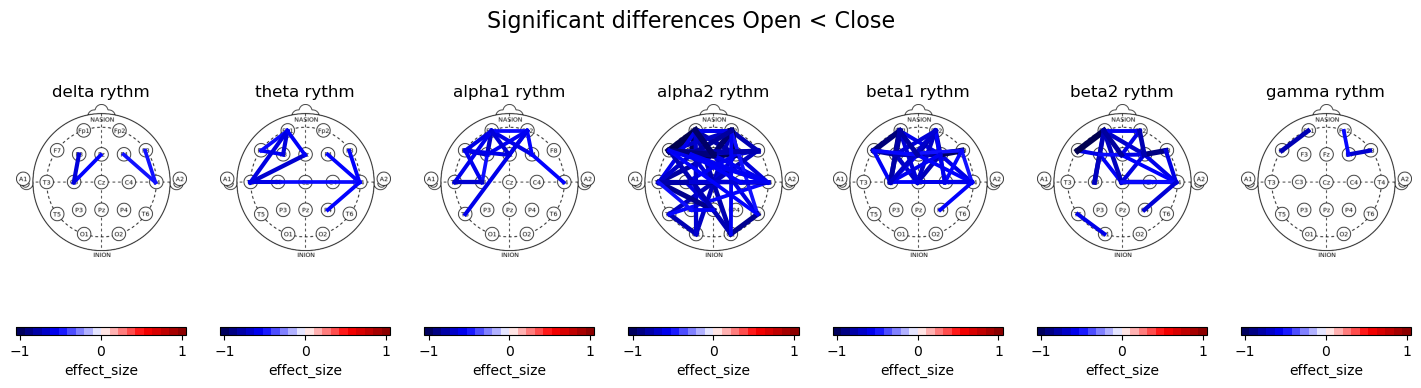

In [94]:
fig = draw_obj.draw_by_df(small_stat_df, band=bands,
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

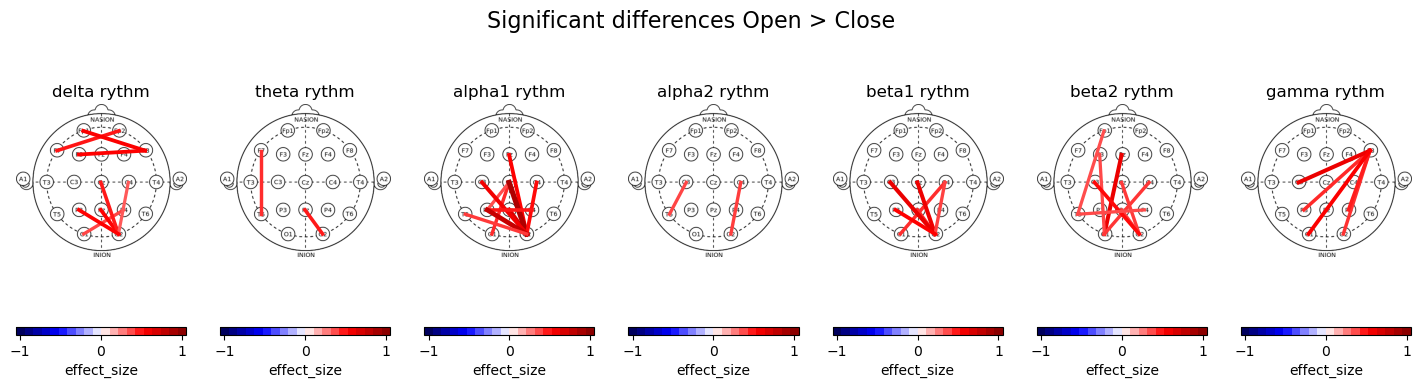

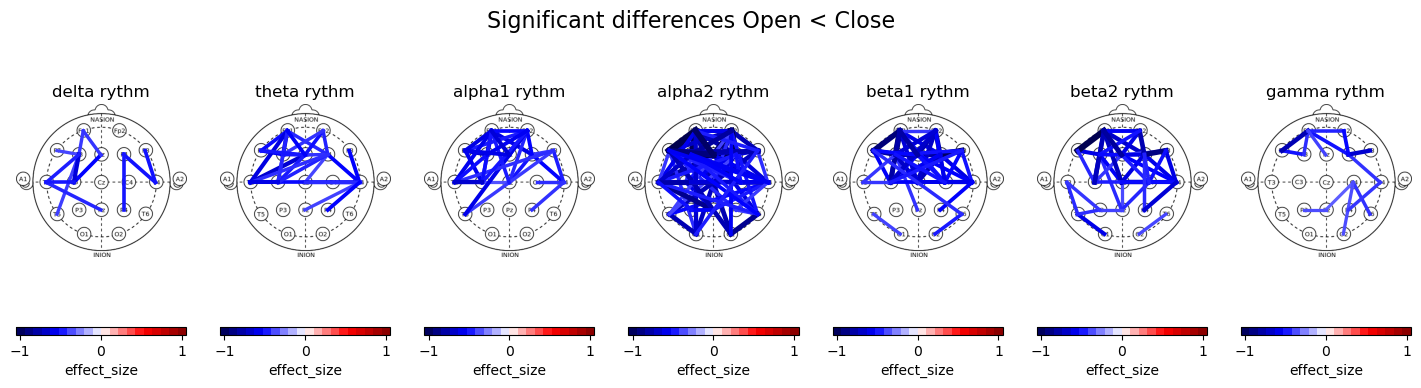

In [95]:
fig = draw_obj.draw_by_df(small_stat_df, band=bands,
                                 filter_by='sign_eff_thrs',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')